In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gender-recognizer/dataset/MEN/20240705_112131.jpg
/kaggle/input/gender-recognizer/dataset/MEN/20240705_133142.jpg
/kaggle/input/gender-recognizer/dataset/MEN/20240705_160304.jpg
/kaggle/input/gender-recognizer/dataset/MEN/20240609_200332.jpg
/kaggle/input/gender-recognizer/dataset/MEN/20240705_160729.jpg
/kaggle/input/gender-recognizer/dataset/MEN/20240705_114708.jpg
/kaggle/input/gender-recognizer/dataset/MEN/20240705_112707.jpg
/kaggle/input/gender-recognizer/dataset/MEN/20240705_101942.jpg
/kaggle/input/gender-recognizer/dataset/MEN/20240705_154853.jpg
/kaggle/input/gender-recognizer/dataset/MEN/20240609_183952.jpg
/kaggle/input/gender-recognizer/dataset/MEN/20240705_111531.jpg
/kaggle/input/gender-recognizer/dataset/MEN/20240705_160616.jpg
/kaggle/input/gender-recognizer/dataset/MEN/20240609_202926.jpg
/kaggle/input/gender-recognizer/dataset/MEN/20240705_115955.jpg
/kaggle/input/gender-recognizer/dataset/MEN/20240705_122708.jpg
/kaggle/input/gender-recognizer/dataset/

In [2]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

import torch
import torchvision
import torchmetrics
import torch.nn as nn

from torch.utils.data import Dataset
from torchvision.io import read_image
from torch.utils.data import DataLoader

from torchvision import transforms 
from sklearn.model_selection import train_test_split

import torchinfo
from torch.optim.lr_scheduler import StepLR
from torchvision import models

In [3]:
dataset_loc = "/kaggle/input/gender-recognizer/dataset"

In [4]:
os.listdir(dataset_loc)

['MEN', 'WOMAN']

In [5]:
men_data = os.path.join(dataset_loc, "MEN")
women_data = os.path.join(dataset_loc, "WOMAN")

In [6]:
print(men_data)
print(women_data)

/kaggle/input/gender-recognizer/dataset/MEN
/kaggle/input/gender-recognizer/dataset/WOMAN


In [7]:
data_df = pd.DataFrame(columns=["filename", "label"])
for d in tqdm(os.listdir(men_data)):
    df = pd.DataFrame({"filename":os.path.join(men_data, d), "label":"MEN"}, index=[0])
    data_df = pd.concat([data_df, df], ignore_index=True)

100%|██████████| 646/646 [00:00<00:00, 2401.97it/s]


In [8]:
for d in tqdm(os.listdir(women_data)):
    df = pd.DataFrame({"filename":os.path.join(women_data, d), "label":"WOMAN"}, index=[0])
    data_df = pd.concat([data_df, df], ignore_index=True)

100%|██████████| 647/647 [00:00<00:00, 2171.37it/s]


In [9]:
data_df.head()

,filename,label
0,/kaggle/input/gender-recognizer/dataset/MEN/20...,MEN
1,/kaggle/input/gender-recognizer/dataset/MEN/20...,MEN
2,/kaggle/input/gender-recognizer/dataset/MEN/20...,MEN
3,/kaggle/input/gender-recognizer/dataset/MEN/20...,MEN
4,/kaggle/input/gender-recognizer/dataset/MEN/20...,MEN


In [10]:
data_df.tail()

,filename,label
1288,/kaggle/input/gender-recognizer/dataset/WOMAN/...,WOMAN
1289,/kaggle/input/gender-recognizer/dataset/WOMAN/...,WOMAN
1290,/kaggle/input/gender-recognizer/dataset/WOMAN/...,WOMAN
1291,/kaggle/input/gender-recognizer/dataset/WOMAN/...,WOMAN
1292,/kaggle/input/gender-recognizer/dataset/WOMAN/...,WOMAN


In [11]:
data_df=data_df.sample(frac=1.0).reset_index(drop=True)

In [12]:
data_df.head()

,filename,label
0,/kaggle/input/gender-recognizer/dataset/MEN/20...,MEN
1,/kaggle/input/gender-recognizer/dataset/MEN/20...,MEN
2,/kaggle/input/gender-recognizer/dataset/MEN/20...,MEN
3,/kaggle/input/gender-recognizer/dataset/MEN/20...,MEN
4,/kaggle/input/gender-recognizer/dataset/WOMAN/...,WOMAN


In [13]:
data_df.tail()

,filename,label
1288,/kaggle/input/gender-recognizer/dataset/WOMAN/...,WOMAN
1289,/kaggle/input/gender-recognizer/dataset/MEN/20...,MEN
1290,/kaggle/input/gender-recognizer/dataset/MEN/20...,MEN
1291,/kaggle/input/gender-recognizer/dataset/MEN/20...,MEN
1292,/kaggle/input/gender-recognizer/dataset/MEN/20...,MEN


In [14]:
for i in data_df["filename"]:
    if  (not i.endswith(".jpg")) and (not i.endswith(".png")):
        print(i)

/kaggle/input/gender-recognizer/dataset/WOMAN/6c6dcc79cb44204e1eca93838d2ab4eb6c2f027a_high.webp
/kaggle/input/gender-recognizer/dataset/WOMAN/MEN


In [15]:
data_df = data_df[data_df["filename"].str.endswith((".jpg", ".png"))]

In [16]:
data_df

,filename,label
0,/kaggle/input/gender-recognizer/dataset/MEN/20...,MEN
1,/kaggle/input/gender-recognizer/dataset/MEN/20...,MEN
2,/kaggle/input/gender-recognizer/dataset/MEN/20...,MEN
3,/kaggle/input/gender-recognizer/dataset/MEN/20...,MEN
4,/kaggle/input/gender-recognizer/dataset/WOMAN/...,WOMAN
...,...,...
1288,/kaggle/input/gender-recognizer/dataset/WOMAN/...,WOMAN
1289,/kaggle/input/gender-recognizer/dataset/MEN/20...,MEN
1290,/kaggle/input/gender-recognizer/dataset/MEN/20...,MEN
1291,/kaggle/input/gender-recognizer/dataset/MEN/20...,MEN


In [17]:
INPUT_SHAPE = 256
train_transforms = transforms.Compose([
    transforms.Resize((INPUT_SHAPE, INPUT_SHAPE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAutocontrast(),
    transforms.RandomAdjustSharpness(2),
])

# Only reshape test data
test_transforms = transforms.Compose([
    transforms.Resize((INPUT_SHAPE, INPUT_SHAPE)),
])

In [18]:
class GenderRecognitionDataset(Dataset):
    def __init__(self, dataset_df, transform):
        self.dataset_df = dataset_df
        self.filenames = self.dataset_df["filename"].to_list()
        self.labels = self.dataset_df["label"].to_list()
        self.classes = sorted(list(dataset_df['label'].unique()))
        self.class_to_idx = {cls_name: _ for _, cls_name in enumerate(self.classes)}
        self.transform = transform
    
    def __len__(self):
        return len(self.dataset_df)
    
    def __getitem__(self, idx):
        self.filename = self.filenames[idx]
        image = read_image(self.filename)
        image = image/255.0
        image = self.transform(image)
        label = self.labels[idx]
        label = torch.tensor(self.class_to_idx[label])
        return image, label

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


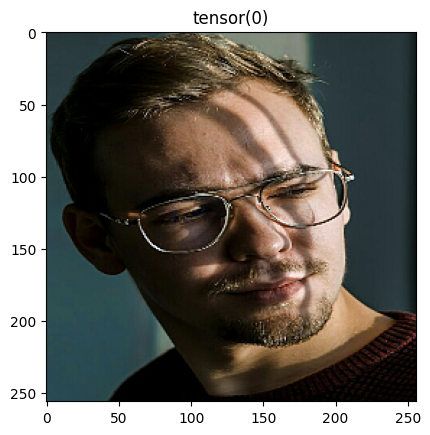

In [19]:
gdr = GenderRecognitionDataset(data_df, transform=train_transforms)
img, lab = next(iter(gdr))
plt.imshow(img.permute(1,2,0))
plt.title(lab)
plt.show()

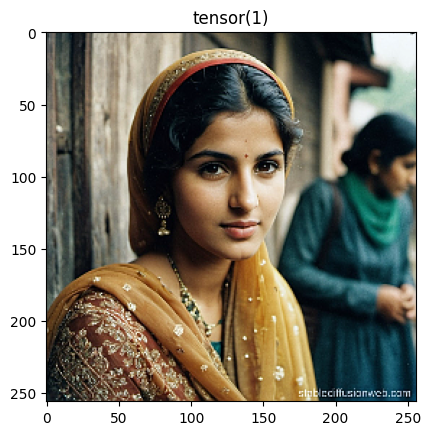

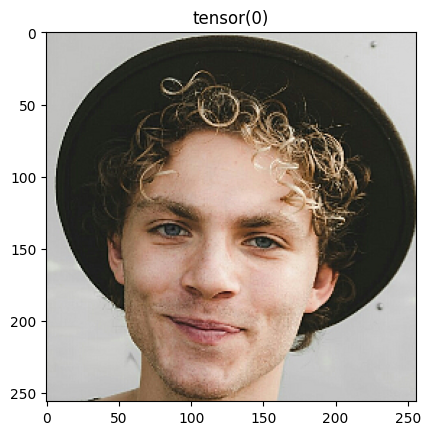

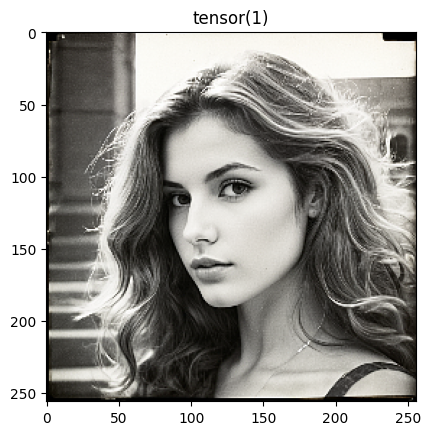

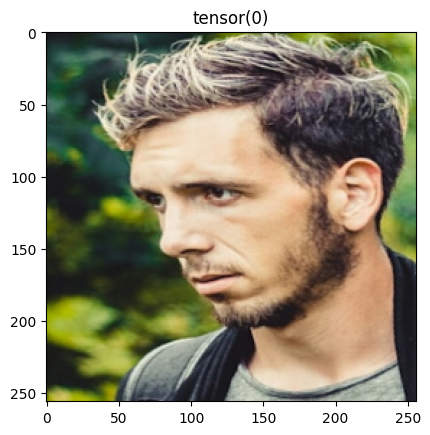

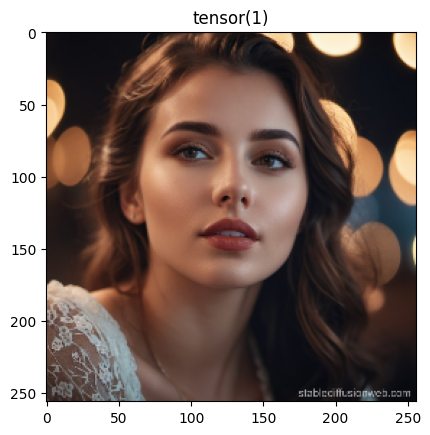

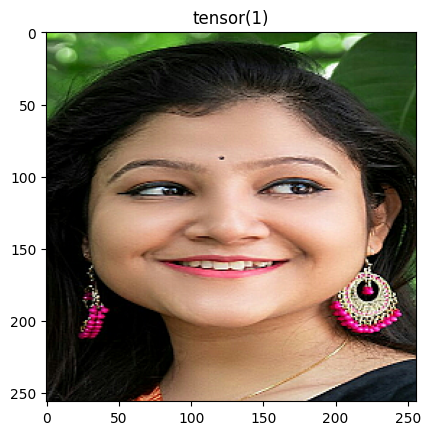

In [20]:
train_loader = DataLoader(gdr, batch_size=6, shuffle=True)
sample_images, sample_labels = next(iter(train_loader))
for img, label in zip(sample_images, sample_labels):
    plt.imshow(img.permute(1,2,0))
    plt.title(label)
    plt.show()

In [21]:
train_df, test_df = train_test_split(data_df, test_size=0.20, random_state=42)

In [22]:
train_data = GenderRecognitionDataset(train_df, train_transforms)
test_data = GenderRecognitionDataset(test_df, test_transforms)

train_dataLoader = DataLoader(train_data, batch_size=8, shuffle=True)
test_dataLoader = DataLoader(test_data, batch_size=1, shuffle=True)

In [23]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [24]:
print(device)

cuda:0


In [25]:
m = models.efficientnet_b1(weights="IMAGENET1K_V1").features

Downloading: "https://download.pytorch.org/models/efficientnet_b1_rwightman-bac287d4.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1_rwightman-bac287d4.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 70.3MB/s]


In [26]:
m(sample_images).shape

torch.Size([6, 1280, 8, 8])

In [27]:
class GenderNetVGG(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = models.efficientnet_b1(weights="IMAGENET1K_V1").features
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1280*8*8, 8),
            nn.ReLU(),
            nn.Linear(8, 2),
            nn.Softmax()
            )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x
        

In [28]:
model = GenderNetVGG().to(device)

In [29]:
torchinfo.summary(model,input_size=(1,3,INPUT_SHAPE,INPUT_SHAPE))

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layer (type:depth-idx)                                  Output Shape              Param #
GenderNetVGG                                            [1, 2]                    --
├─Sequential: 1-1                                       [1, 1280, 8, 8]           --
│    └─Conv2dNormActivation: 2-1                        [1, 32, 128, 128]         --
│    │    └─Conv2d: 3-1                                 [1, 32, 128, 128]         864
│    │    └─BatchNorm2d: 3-2                            [1, 32, 128, 128]         64
│    │    └─SiLU: 3-3                                   [1, 32, 128, 128]         --
│    └─Sequential: 2-2                                  [1, 16, 128, 128]         --
│    │    └─MBConv: 3-4                                 [1, 16, 128, 128]         1,448
│    │    └─MBConv: 3-5                                 [1, 16, 128, 128]         612
│    └─Sequential: 2-3                                  [1, 24, 64, 64]           --
│    │    └─MBConv: 3-6                                

In [30]:
training_loss = 0.0
validation_loss = 0.0 

metric = torchmetrics.Accuracy(task="multiclass", num_classes=2).to(device)


In [31]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
# scheduler = StepLR(optimizer, step_size=2, gamma=0.01)

In [32]:
for epoch in range(100):
    for images, labels in tqdm(train_dataLoader, desc= f"Training at Epoch : {epoch}"):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        predictions = model(images)
        losses = criterion(predictions, labels)
        acc = metric(labels, predictions.argmax(dim=-1)) 
        training_loss += losses.item()
        losses.backward()
        optimizer.step()
#         scheduler.step()
    acc = metric.compute()
    train_loss = training_loss / len(train_dataLoader)
    metric.reset()
    model.eval()
    with torch.no_grad():
        for images, labels in tqdm(test_dataLoader,  desc= f"Validation at Epoch : {epoch}"):
            images =  images.to(device)
            labels = labels.to(device)
            val_pred = model(images)
            losses = criterion(val_pred, labels)
            validation_loss += losses.item()
            val_acc = metric(labels, val_pred.argmax(dim=-1))
        val_acc = metric.compute()
        val_loss = validation_loss / len(test_dataLoader)
        print(f"Epoch : {epoch} |  Accuracy : {acc : .2f} | Training Loss : {train_loss : .2f} | Validation Accuracy : {val_acc : .2f} | Validation Loss : {val_loss : .2f}")
        metric.reset()
        model.train()
    
        

Validation at Epoch : 0: 100%|██████████| 259/259 [00:09<00:00, 27.22it/s]


Epoch : 0 |  Accuracy :  0.66 | Training Loss :  0.62 | Validation Accuracy :  0.82 | Validation Loss :  0.56


Validation at Epoch : 1: 100%|██████████| 259/259 [00:07<00:00, 34.49it/s]


Epoch : 1 |  Accuracy :  0.92 | Training Loss :  1.11 | Validation Accuracy :  0.94 | Validation Loss :  1.03


Validation at Epoch : 2: 100%|██████████| 259/259 [00:07<00:00, 34.61it/s]


Epoch : 2 |  Accuracy :  0.94 | Training Loss :  1.52 | Validation Accuracy :  0.95 | Validation Loss :  1.44


Validation at Epoch : 3: 100%|██████████| 259/259 [00:07<00:00, 34.14it/s]


Epoch : 3 |  Accuracy :  0.95 | Training Loss :  1.91 | Validation Accuracy :  0.96 | Validation Loss :  1.83


Validation at Epoch : 4: 100%|██████████| 259/259 [00:07<00:00, 34.93it/s]


Epoch : 4 |  Accuracy :  0.96 | Training Loss :  2.28 | Validation Accuracy :  0.97 | Validation Loss :  2.21


Validation at Epoch : 5: 100%|██████████| 259/259 [00:07<00:00, 34.47it/s]


Epoch : 5 |  Accuracy :  0.97 | Training Loss :  2.64 | Validation Accuracy :  0.97 | Validation Loss :  2.59


Validation at Epoch : 6: 100%|██████████| 259/259 [00:07<00:00, 34.98it/s]


Epoch : 6 |  Accuracy :  0.97 | Training Loss :  2.99 | Validation Accuracy :  0.96 | Validation Loss :  2.96


Validation at Epoch : 7: 100%|██████████| 259/259 [00:07<00:00, 34.24it/s]


Epoch : 7 |  Accuracy :  0.98 | Training Loss :  3.33 | Validation Accuracy :  0.97 | Validation Loss :  3.33


Validation at Epoch : 8: 100%|██████████| 259/259 [00:07<00:00, 35.36it/s]


Epoch : 8 |  Accuracy :  0.99 | Training Loss :  3.67 | Validation Accuracy :  0.97 | Validation Loss :  3.69


Validation at Epoch : 9: 100%|██████████| 259/259 [00:07<00:00, 35.13it/s]


Epoch : 9 |  Accuracy :  0.98 | Training Loss :  4.00 | Validation Accuracy :  0.97 | Validation Loss :  4.04


Validation at Epoch : 10: 100%|██████████| 259/259 [00:07<00:00, 34.61it/s]


Epoch : 10 |  Accuracy :  0.98 | Training Loss :  4.34 | Validation Accuracy :  0.98 | Validation Loss :  4.40


Validation at Epoch : 11: 100%|██████████| 259/259 [00:07<00:00, 34.11it/s]


Epoch : 11 |  Accuracy :  0.99 | Training Loss :  4.67 | Validation Accuracy :  0.98 | Validation Loss :  4.75


Validation at Epoch : 12: 100%|██████████| 259/259 [00:07<00:00, 35.05it/s]


Epoch : 12 |  Accuracy :  0.99 | Training Loss :  5.00 | Validation Accuracy :  0.98 | Validation Loss :  5.10


Validation at Epoch : 13: 100%|██████████| 259/259 [00:07<00:00, 35.41it/s]


Epoch : 13 |  Accuracy :  0.99 | Training Loss :  5.33 | Validation Accuracy :  0.98 | Validation Loss :  5.45


Validation at Epoch : 14: 100%|██████████| 259/259 [00:07<00:00, 34.85it/s]


Epoch : 14 |  Accuracy :  1.00 | Training Loss :  5.65 | Validation Accuracy :  0.97 | Validation Loss :  5.81


Validation at Epoch : 15: 100%|██████████| 259/259 [00:07<00:00, 35.08it/s]


Epoch : 15 |  Accuracy :  1.00 | Training Loss :  5.98 | Validation Accuracy :  0.98 | Validation Loss :  6.16


Validation at Epoch : 16: 100%|██████████| 259/259 [00:07<00:00, 34.58it/s]


Epoch : 16 |  Accuracy :  1.00 | Training Loss :  6.30 | Validation Accuracy :  0.98 | Validation Loss :  6.51


Validation at Epoch : 17: 100%|██████████| 259/259 [00:07<00:00, 34.07it/s]


Epoch : 17 |  Accuracy :  1.00 | Training Loss :  6.62 | Validation Accuracy :  0.97 | Validation Loss :  6.86


Validation at Epoch : 18: 100%|██████████| 259/259 [00:07<00:00, 35.18it/s]


Epoch : 18 |  Accuracy :  0.99 | Training Loss :  6.94 | Validation Accuracy :  0.98 | Validation Loss :  7.21


Validation at Epoch : 19: 100%|██████████| 259/259 [00:07<00:00, 35.10it/s]


Epoch : 19 |  Accuracy :  1.00 | Training Loss :  7.26 | Validation Accuracy :  0.97 | Validation Loss :  7.56


Validation at Epoch : 20: 100%|██████████| 259/259 [00:07<00:00, 34.80it/s]


Epoch : 20 |  Accuracy :  1.00 | Training Loss :  7.58 | Validation Accuracy :  0.98 | Validation Loss :  7.91


Validation at Epoch : 21: 100%|██████████| 259/259 [00:07<00:00, 34.24it/s]


Epoch : 21 |  Accuracy :  1.00 | Training Loss :  7.90 | Validation Accuracy :  0.98 | Validation Loss :  8.25


Validation at Epoch : 22: 100%|██████████| 259/259 [00:07<00:00, 33.86it/s]


Epoch : 22 |  Accuracy :  1.00 | Training Loss :  8.22 | Validation Accuracy :  0.98 | Validation Loss :  8.59


Validation at Epoch : 23: 100%|██████████| 259/259 [00:07<00:00, 34.75it/s]


Epoch : 23 |  Accuracy :  1.00 | Training Loss :  8.53 | Validation Accuracy :  0.98 | Validation Loss :  8.93


Validation at Epoch : 24: 100%|██████████| 259/259 [00:07<00:00, 34.92it/s]


Epoch : 24 |  Accuracy :  1.00 | Training Loss :  8.85 | Validation Accuracy :  0.98 | Validation Loss :  9.28


Validation at Epoch : 25: 100%|██████████| 259/259 [00:07<00:00, 35.39it/s]


Epoch : 25 |  Accuracy :  1.00 | Training Loss :  9.17 | Validation Accuracy :  0.98 | Validation Loss :  9.62


Validation at Epoch : 26: 100%|██████████| 259/259 [00:07<00:00, 34.72it/s]


Epoch : 26 |  Accuracy :  1.00 | Training Loss :  9.48 | Validation Accuracy :  0.97 | Validation Loss :  9.97


Validation at Epoch : 27: 100%|██████████| 259/259 [00:07<00:00, 35.35it/s]


Epoch : 27 |  Accuracy :  1.00 | Training Loss :  9.80 | Validation Accuracy :  0.98 | Validation Loss :  10.31


Validation at Epoch : 28: 100%|██████████| 259/259 [00:07<00:00, 35.12it/s]


Epoch : 28 |  Accuracy :  1.00 | Training Loss :  10.12 | Validation Accuracy :  0.98 | Validation Loss :  10.65


Validation at Epoch : 29: 100%|██████████| 259/259 [00:07<00:00, 34.97it/s]


Epoch : 29 |  Accuracy :  1.00 | Training Loss :  10.43 | Validation Accuracy :  0.98 | Validation Loss :  10.99


Validation at Epoch : 30: 100%|██████████| 259/259 [00:07<00:00, 34.31it/s]


Epoch : 30 |  Accuracy :  1.00 | Training Loss :  10.75 | Validation Accuracy :  0.98 | Validation Loss :  11.34


Validation at Epoch : 31: 100%|██████████| 259/259 [00:07<00:00, 34.64it/s]


Epoch : 31 |  Accuracy :  1.00 | Training Loss :  11.06 | Validation Accuracy :  0.97 | Validation Loss :  11.69


Validation at Epoch : 32: 100%|██████████| 259/259 [00:07<00:00, 34.76it/s]


Epoch : 32 |  Accuracy :  1.00 | Training Loss :  11.38 | Validation Accuracy :  0.98 | Validation Loss :  12.03


Validation at Epoch : 33: 100%|██████████| 259/259 [00:07<00:00, 35.29it/s]


Epoch : 33 |  Accuracy :  1.00 | Training Loss :  11.69 | Validation Accuracy :  0.98 | Validation Loss :  12.38


Validation at Epoch : 34: 100%|██████████| 259/259 [00:07<00:00, 35.39it/s]


Epoch : 34 |  Accuracy :  1.00 | Training Loss :  12.01 | Validation Accuracy :  0.98 | Validation Loss :  12.72


Validation at Epoch : 35: 100%|██████████| 259/259 [00:07<00:00, 34.89it/s]


Epoch : 35 |  Accuracy :  1.00 | Training Loss :  12.33 | Validation Accuracy :  0.98 | Validation Loss :  13.06


Validation at Epoch : 36: 100%|██████████| 259/259 [00:07<00:00, 35.02it/s]


Epoch : 36 |  Accuracy :  1.00 | Training Loss :  12.64 | Validation Accuracy :  0.98 | Validation Loss :  13.40


Validation at Epoch : 37: 100%|██████████| 259/259 [00:07<00:00, 33.38it/s]


Epoch : 37 |  Accuracy :  1.00 | Training Loss :  12.96 | Validation Accuracy :  0.98 | Validation Loss :  13.74


Validation at Epoch : 38: 100%|██████████| 259/259 [00:07<00:00, 35.24it/s]


Epoch : 38 |  Accuracy :  1.00 | Training Loss :  13.27 | Validation Accuracy :  0.98 | Validation Loss :  14.08


Validation at Epoch : 39: 100%|██████████| 259/259 [00:07<00:00, 34.55it/s]


Epoch : 39 |  Accuracy :  1.00 | Training Loss :  13.59 | Validation Accuracy :  0.97 | Validation Loss :  14.43


Validation at Epoch : 40: 100%|██████████| 259/259 [00:07<00:00, 34.63it/s]


Epoch : 40 |  Accuracy :  1.00 | Training Loss :  13.90 | Validation Accuracy :  0.98 | Validation Loss :  14.78


Validation at Epoch : 41: 100%|██████████| 259/259 [00:07<00:00, 33.91it/s]


Epoch : 41 |  Accuracy :  1.00 | Training Loss :  14.21 | Validation Accuracy :  0.98 | Validation Loss :  15.12


Validation at Epoch : 42: 100%|██████████| 259/259 [00:07<00:00, 34.94it/s]


Epoch : 42 |  Accuracy :  1.00 | Training Loss :  14.53 | Validation Accuracy :  0.98 | Validation Loss :  15.46


Validation at Epoch : 43: 100%|██████████| 259/259 [00:07<00:00, 34.28it/s]


Epoch : 43 |  Accuracy :  1.00 | Training Loss :  14.84 | Validation Accuracy :  0.98 | Validation Loss :  15.80


Validation at Epoch : 44: 100%|██████████| 259/259 [00:07<00:00, 34.89it/s]


Epoch : 44 |  Accuracy :  1.00 | Training Loss :  15.16 | Validation Accuracy :  0.98 | Validation Loss :  16.14


Validation at Epoch : 45: 100%|██████████| 259/259 [00:07<00:00, 35.37it/s]


Epoch : 45 |  Accuracy :  1.00 | Training Loss :  15.47 | Validation Accuracy :  0.97 | Validation Loss :  16.48


Validation at Epoch : 46: 100%|██████████| 259/259 [00:07<00:00, 35.15it/s]


Epoch : 46 |  Accuracy :  1.00 | Training Loss :  15.79 | Validation Accuracy :  0.97 | Validation Loss :  16.83


Validation at Epoch : 47: 100%|██████████| 259/259 [00:07<00:00, 35.86it/s]


Epoch : 47 |  Accuracy :  1.00 | Training Loss :  16.10 | Validation Accuracy :  0.98 | Validation Loss :  17.17


Validation at Epoch : 48: 100%|██████████| 259/259 [00:07<00:00, 34.58it/s]


Epoch : 48 |  Accuracy :  1.00 | Training Loss :  16.42 | Validation Accuracy :  0.98 | Validation Loss :  17.51


Validation at Epoch : 49: 100%|██████████| 259/259 [00:07<00:00, 35.25it/s]


Epoch : 49 |  Accuracy :  1.00 | Training Loss :  16.73 | Validation Accuracy :  0.98 | Validation Loss :  17.85


Validation at Epoch : 50: 100%|██████████| 259/259 [00:07<00:00, 34.60it/s]


Epoch : 50 |  Accuracy :  1.00 | Training Loss :  17.04 | Validation Accuracy :  0.98 | Validation Loss :  18.18


Validation at Epoch : 51: 100%|██████████| 259/259 [00:07<00:00, 34.51it/s]


Epoch : 51 |  Accuracy :  1.00 | Training Loss :  17.36 | Validation Accuracy :  0.98 | Validation Loss :  18.53


Validation at Epoch : 52: 100%|██████████| 259/259 [00:07<00:00, 33.26it/s]


Epoch : 52 |  Accuracy :  1.00 | Training Loss :  17.67 | Validation Accuracy :  0.98 | Validation Loss :  18.86


Validation at Epoch : 53: 100%|██████████| 259/259 [00:07<00:00, 34.78it/s]


Epoch : 53 |  Accuracy :  1.00 | Training Loss :  17.99 | Validation Accuracy :  0.98 | Validation Loss :  19.21


Validation at Epoch : 54: 100%|██████████| 259/259 [00:07<00:00, 34.63it/s]


Epoch : 54 |  Accuracy :  1.00 | Training Loss :  18.30 | Validation Accuracy :  0.95 | Validation Loss :  19.56


Validation at Epoch : 55: 100%|██████████| 259/259 [00:07<00:00, 34.58it/s]


Epoch : 55 |  Accuracy :  1.00 | Training Loss :  18.61 | Validation Accuracy :  0.98 | Validation Loss :  19.90


Validation at Epoch : 56: 100%|██████████| 259/259 [00:07<00:00, 35.33it/s]


Epoch : 56 |  Accuracy :  1.00 | Training Loss :  18.93 | Validation Accuracy :  0.98 | Validation Loss :  20.24


Validation at Epoch : 57: 100%|██████████| 259/259 [00:07<00:00, 34.75it/s]


Epoch : 57 |  Accuracy :  1.00 | Training Loss :  19.24 | Validation Accuracy :  0.98 | Validation Loss :  20.58


Validation at Epoch : 58: 100%|██████████| 259/259 [00:07<00:00, 35.64it/s]


Epoch : 58 |  Accuracy :  1.00 | Training Loss :  19.56 | Validation Accuracy :  0.98 | Validation Loss :  20.92


Validation at Epoch : 59: 100%|██████████| 259/259 [00:07<00:00, 35.23it/s]


Epoch : 59 |  Accuracy :  1.00 | Training Loss :  19.87 | Validation Accuracy :  0.98 | Validation Loss :  21.25


Validation at Epoch : 60: 100%|██████████| 259/259 [00:07<00:00, 34.62it/s]


Epoch : 60 |  Accuracy :  1.00 | Training Loss :  20.18 | Validation Accuracy :  0.98 | Validation Loss :  21.59


Validation at Epoch : 61: 100%|██████████| 259/259 [00:07<00:00, 34.64it/s]


Epoch : 61 |  Accuracy :  1.00 | Training Loss :  20.50 | Validation Accuracy :  0.98 | Validation Loss :  21.93


Validation at Epoch : 62: 100%|██████████| 259/259 [00:07<00:00, 34.58it/s]


Epoch : 62 |  Accuracy :  1.00 | Training Loss :  20.81 | Validation Accuracy :  0.98 | Validation Loss :  22.27


Validation at Epoch : 63: 100%|██████████| 259/259 [00:07<00:00, 35.45it/s]


Epoch : 63 |  Accuracy :  1.00 | Training Loss :  21.13 | Validation Accuracy :  0.98 | Validation Loss :  22.60


Validation at Epoch : 64: 100%|██████████| 259/259 [00:07<00:00, 34.65it/s]


Epoch : 64 |  Accuracy :  1.00 | Training Loss :  21.44 | Validation Accuracy :  0.98 | Validation Loss :  22.94


Validation at Epoch : 65: 100%|██████████| 259/259 [00:07<00:00, 35.37it/s]


Epoch : 65 |  Accuracy :  1.00 | Training Loss :  21.75 | Validation Accuracy :  0.97 | Validation Loss :  23.28


Validation at Epoch : 66: 100%|██████████| 259/259 [00:07<00:00, 35.65it/s]


Epoch : 66 |  Accuracy :  1.00 | Training Loss :  22.07 | Validation Accuracy :  0.98 | Validation Loss :  23.62


Validation at Epoch : 67: 100%|██████████| 259/259 [00:07<00:00, 34.09it/s]


Epoch : 67 |  Accuracy :  1.00 | Training Loss :  22.38 | Validation Accuracy :  0.98 | Validation Loss :  23.96


Validation at Epoch : 68: 100%|██████████| 259/259 [00:07<00:00, 35.35it/s]


Epoch : 68 |  Accuracy :  1.00 | Training Loss :  22.69 | Validation Accuracy :  0.97 | Validation Loss :  24.30


Validation at Epoch : 69: 100%|██████████| 259/259 [00:07<00:00, 34.48it/s]


Epoch : 69 |  Accuracy :  1.00 | Training Loss :  23.01 | Validation Accuracy :  0.97 | Validation Loss :  24.64


Validation at Epoch : 70: 100%|██████████| 259/259 [00:07<00:00, 34.55it/s]


Epoch : 70 |  Accuracy :  1.00 | Training Loss :  23.32 | Validation Accuracy :  0.98 | Validation Loss :  24.98


Validation at Epoch : 71: 100%|██████████| 259/259 [00:07<00:00, 34.41it/s]


Epoch : 71 |  Accuracy :  1.00 | Training Loss :  23.64 | Validation Accuracy :  0.98 | Validation Loss :  25.32


Validation at Epoch : 72: 100%|██████████| 259/259 [00:07<00:00, 34.58it/s]


Epoch : 72 |  Accuracy :  1.00 | Training Loss :  23.95 | Validation Accuracy :  0.98 | Validation Loss :  25.66


Validation at Epoch : 73: 100%|██████████| 259/259 [00:07<00:00, 34.89it/s]


Epoch : 73 |  Accuracy :  1.00 | Training Loss :  24.26 | Validation Accuracy :  0.98 | Validation Loss :  25.99


Validation at Epoch : 74: 100%|██████████| 259/259 [00:07<00:00, 35.37it/s]


Epoch : 74 |  Accuracy :  1.00 | Training Loss :  24.58 | Validation Accuracy :  0.98 | Validation Loss :  26.33


Validation at Epoch : 75: 100%|██████████| 259/259 [00:07<00:00, 34.30it/s]


Epoch : 75 |  Accuracy :  1.00 | Training Loss :  24.89 | Validation Accuracy :  0.98 | Validation Loss :  26.67


Validation at Epoch : 76: 100%|██████████| 259/259 [00:07<00:00, 35.51it/s]


Epoch : 76 |  Accuracy :  1.00 | Training Loss :  25.21 | Validation Accuracy :  0.98 | Validation Loss :  27.01


Validation at Epoch : 77: 100%|██████████| 259/259 [00:07<00:00, 35.03it/s]


Epoch : 77 |  Accuracy :  1.00 | Training Loss :  25.52 | Validation Accuracy :  0.98 | Validation Loss :  27.34


Validation at Epoch : 78: 100%|██████████| 259/259 [00:07<00:00, 35.51it/s]


Epoch : 78 |  Accuracy :  1.00 | Training Loss :  25.83 | Validation Accuracy :  0.98 | Validation Loss :  27.68


Validation at Epoch : 79: 100%|██████████| 259/259 [00:07<00:00, 35.52it/s]


Epoch : 79 |  Accuracy :  1.00 | Training Loss :  26.15 | Validation Accuracy :  0.98 | Validation Loss :  28.02


Validation at Epoch : 80: 100%|██████████| 259/259 [00:07<00:00, 34.80it/s]


Epoch : 80 |  Accuracy :  1.00 | Training Loss :  26.46 | Validation Accuracy :  0.96 | Validation Loss :  28.37


Validation at Epoch : 81: 100%|██████████| 259/259 [00:07<00:00, 34.59it/s]


Epoch : 81 |  Accuracy :  1.00 | Training Loss :  26.77 | Validation Accuracy :  0.97 | Validation Loss :  28.71


Validation at Epoch : 82: 100%|██████████| 259/259 [00:07<00:00, 34.38it/s]


Epoch : 82 |  Accuracy :  1.00 | Training Loss :  27.09 | Validation Accuracy :  0.98 | Validation Loss :  29.04


Validation at Epoch : 83: 100%|██████████| 259/259 [00:07<00:00, 34.86it/s]


Epoch : 83 |  Accuracy :  1.00 | Training Loss :  27.40 | Validation Accuracy :  0.98 | Validation Loss :  29.38


Validation at Epoch : 84: 100%|██████████| 259/259 [00:07<00:00, 35.13it/s]


Epoch : 84 |  Accuracy :  1.00 | Training Loss :  27.71 | Validation Accuracy :  0.98 | Validation Loss :  29.71


Validation at Epoch : 85: 100%|██████████| 259/259 [00:07<00:00, 35.35it/s]


Epoch : 85 |  Accuracy :  1.00 | Training Loss :  28.03 | Validation Accuracy :  0.97 | Validation Loss :  30.06


Validation at Epoch : 86: 100%|██████████| 259/259 [00:07<00:00, 35.15it/s]


Epoch : 86 |  Accuracy :  1.00 | Training Loss :  28.34 | Validation Accuracy :  0.97 | Validation Loss :  30.40


Validation at Epoch : 87: 100%|██████████| 259/259 [00:07<00:00, 35.24it/s]


Epoch : 87 |  Accuracy :  1.00 | Training Loss :  28.65 | Validation Accuracy :  0.98 | Validation Loss :  30.74


Validation at Epoch : 88: 100%|██████████| 259/259 [00:07<00:00, 35.08it/s]


Epoch : 88 |  Accuracy :  1.00 | Training Loss :  28.97 | Validation Accuracy :  0.98 | Validation Loss :  31.08


Validation at Epoch : 89: 100%|██████████| 259/259 [00:07<00:00, 35.21it/s]


Epoch : 89 |  Accuracy :  1.00 | Training Loss :  29.28 | Validation Accuracy :  0.98 | Validation Loss :  31.41


Validation at Epoch : 90: 100%|██████████| 259/259 [00:07<00:00, 34.69it/s]


Epoch : 90 |  Accuracy :  1.00 | Training Loss :  29.59 | Validation Accuracy :  0.98 | Validation Loss :  31.75


Validation at Epoch : 91: 100%|██████████| 259/259 [00:07<00:00, 34.08it/s]


Epoch : 91 |  Accuracy :  1.00 | Training Loss :  29.91 | Validation Accuracy :  0.98 | Validation Loss :  32.09


Validation at Epoch : 92: 100%|██████████| 259/259 [00:07<00:00, 35.10it/s]


Epoch : 92 |  Accuracy :  1.00 | Training Loss :  30.22 | Validation Accuracy :  0.98 | Validation Loss :  32.42


Validation at Epoch : 93: 100%|██████████| 259/259 [00:07<00:00, 35.01it/s]


Epoch : 93 |  Accuracy :  1.00 | Training Loss :  30.54 | Validation Accuracy :  0.97 | Validation Loss :  32.76


Validation at Epoch : 94: 100%|██████████| 259/259 [00:07<00:00, 35.56it/s]


Epoch : 94 |  Accuracy :  1.00 | Training Loss :  30.85 | Validation Accuracy :  0.98 | Validation Loss :  33.10


Validation at Epoch : 95: 100%|██████████| 259/259 [00:07<00:00, 35.21it/s]


Epoch : 95 |  Accuracy :  1.00 | Training Loss :  31.16 | Validation Accuracy :  0.98 | Validation Loss :  33.43


Validation at Epoch : 96: 100%|██████████| 259/259 [00:07<00:00, 35.26it/s]


Epoch : 96 |  Accuracy :  1.00 | Training Loss :  31.48 | Validation Accuracy :  0.98 | Validation Loss :  33.77


Validation at Epoch : 97: 100%|██████████| 259/259 [00:07<00:00, 34.17it/s]


Epoch : 97 |  Accuracy :  1.00 | Training Loss :  31.79 | Validation Accuracy :  0.98 | Validation Loss :  34.10


Validation at Epoch : 98: 100%|██████████| 259/259 [00:07<00:00, 34.75it/s]


Epoch : 98 |  Accuracy :  1.00 | Training Loss :  32.10 | Validation Accuracy :  0.98 | Validation Loss :  34.44


Validation at Epoch : 99: 100%|██████████| 259/259 [00:07<00:00, 33.50it/s]

Epoch : 99 |  Accuracy :  1.00 | Training Loss :  32.42 | Validation Accuracy :  0.98 | Validation Loss :  34.78


In [33]:
torch.save(model.state_dict(), './checkpoint_GendeClassification_efficient_b1.pth')